In [6]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# ML Preprocessing + Metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix

# Deep Learning (Keras / TensorFlow)
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

from imblearn.over_sampling import SMOTE

In [34]:
# Load ECG dataset
data = pd.read_csv("ecg.csv", header=None)

print("Shape:", data.shape)

Shape: (4998, 141)


In [38]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [33]:
# Target column is the last one ( 0 / 1 ) normal or abnormal
target_col = data.columns[-1]
print("Target column:", target_col)

Target column: 140


In [ ]:
# Separate features (X) and the target variable (y)
X = data.drop(target_col, axis=1).values  # ecg values
y = data[target_col].values               # normal vs abnormal ( 0 / 1 ) 

# Stratify=y ensures the proportion of classes is the same in train and test sets , avoid class imbalance across train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [13]:
# Now, apply SMOTE only to the training data [ SMOTE (Synthetic Minority Over-sampling Technique) ] 
# Balance the dataset → help the model learn better and avoid bias toward the majority class

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Print the class distribution before and after SMOTE on the training set
print("Before SMOTE (training data):", np.bincount(y_train.astype(int)))
print("After SMOTE (training data) :", np.bincount(y_train_bal.astype(int)))

Before SMOTE (training data): [1663 2335]
After SMOTE (training data) : [2335 2335]


/Users/hemanggs/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


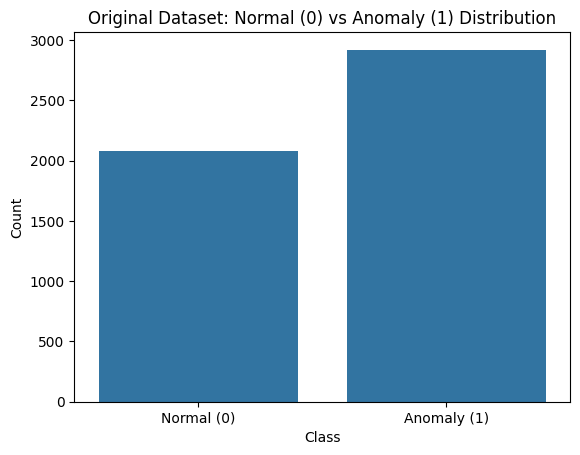

In [14]:
# Plot class distribution of the original, full dataset

sns.countplot(x=y)
plt.title("Original Dataset: Normal (0) vs Anomaly (1) Distribution")
plt.xticks([0, 1], ['Normal (0)', 'Anomaly (1)'])
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [15]:
# Min Max Scaler
# Min-Max Scaler to normalize (rescale) the feature values so that all features lie within a fixed range, usually 0 to 1
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled  = scaler.transform(X_test)

print("Train Shape:", X_train_scaled.shape)
print("Test Shape:", X_test_scaled.shape)

Train Shape: (4670, 140)
Test Shape: (1000, 140)


In [16]:
# Building Autoencoder

# encoder -> code(bottleneck/latent space) -> decoder 

# encoder converts input into latent space representation

# latent space is a low dimensional space that captures only essential features of the data ( held by bottle neck ) 
# a compressed representation of the input
# no of neurons here = no of dimentions in the latent space

# decoder re-constructs the input data from the compressed latent space representation


#  uses : dimensionality reduction , anomaly detection

# applications : 
# identify gender of person from MRI scans based on latent representation ( once in eg: 2D latent representation , 
#  its easy to separate man vs woman instead of trying to distinguish from MRi scans

# Input size = number of features (e.g., 140 ECG values)
input_dim = X_train_scaled.shape[1]

In [18]:
autoencoder = models.Sequential([
    layers.Input(shape=(input_dim,)),      # Input layer

    # Encoder
    layers.Dense(64, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(16, activation="relu"),

    # Bottleneck
    layers.Dense(8, activation="relu"),

    # Decoder
    layers.Dense(16, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(64, activation="relu"),

    # Output (same size as input)
    layers.Dense(input_dim, activation="sigmoid") 
    # works with MinMaxScaler
])

In [20]:
# Compile
autoencoder.compile(optimizer=Adam(learning_rate=0.001),
                    loss="mse",
                    metrics=["mae"])

# Print model summary (layers, params)
autoencoder.summary() 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 64)             │         9,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 140)            │         9,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,668 (92.45 KB)

 Trainable params: 23,668 (92.45 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
#train
history = autoencoder.fit(
    X_train_scaled, X_train_scaled,
    epochs=20, batch_size=512,
    validation_data=(X_test_scaled, X_test_scaled),
    verbose=1
)



Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - mae: 0.0427 - val_loss: 0.0044 - val_mae: 0.0430
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0044 - mae: 0.0422 - val_loss: 0.0044 - val_mae: 0.0428
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0043 - mae: 0.0418 - val_loss: 0.0043 - val_mae: 0.0424
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0044 - mae: 0.0420 - val_loss: 0.0042 - val_mae: 0.0420
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0041 - mae: 0.0412 - val_loss: 0.0041 - val_mae: 0.0417
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0040 - mae: 0.0408 - val_loss: 0.0040 - val_mae: 0.0411
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0039 - mae: 0.0401 - val_loss: 0.0038 - val_mae: 0.0403
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038 - mae: 0.0395 - val_loss: 0.0037 - val_mae: 0.0398
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0037 - mae: 

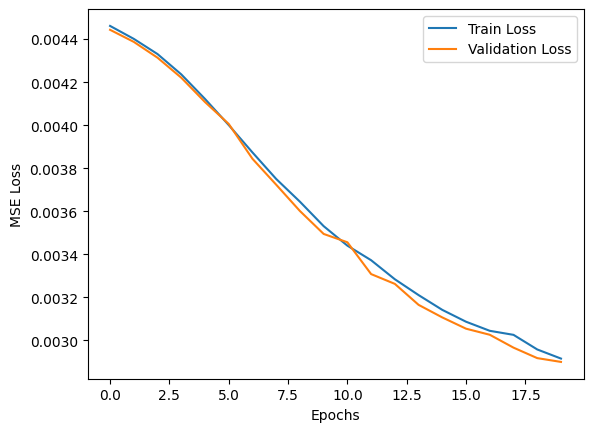

In [25]:
# Plot training and validation loss
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

In [31]:
# Get predictions
X_train_pred = autoencoder.predict(X_train_scaled)
X_test_pred = autoencoder.predict(X_test_scaled)

# Reconstruction errors
# error = (original - reconstructed)^2
train_errors = np.mean(np.square(X_train_scaled - X_train_pred), axis=1)
test_errors = np.mean(np.square(X_test_scaled - X_test_pred), axis=1)


# Threshold (mean of training error + standard deviation of training error)
threshold = np.mean(train_errors) + np.std(train_errors)
print("Reconstruction Threshold:", threshold)

# Anything that is higher than this threshold is Anomaly

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
Reconstruction Threshold: 0.006754834185607773


Accuracy: 0.434


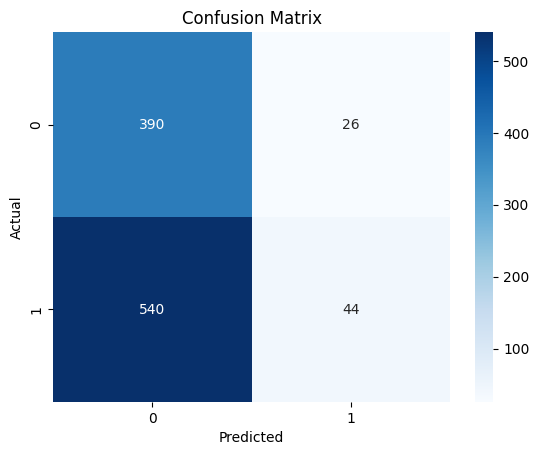

In [32]:
# Predict anomalies
y_pred = [1 if e > threshold else 0 for e in test_errors]

# Accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()